In [ ]:

#############################################
#           GOOGLE COLAB SETUP (if needed)
##############################################
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_folder = "/content/drive/MyDrive/project_folder"

In [ ]:
# Update this path to a folder in your Drive where you want to store your project files.
project_folder = "/content/drive/MyDrive/project_folder"

# Then update your paths accordingly:
dataset_path ="/content/drive/MyDrive/New folder (6)"   # Your raw dataset folder
train_dir = "/content/drive/MyDrive/Processed/train"
val_dir   = "/content/drive/MyDrive/Processed/val"

best_model_path = project_folder + "/best_model.keras"
final_model_path = project_folder + "/my_model.keras"
class_labels_path = project_folder + "/class_labels.txt"

In [ ]:
##############################################
#           IMPORTS & SETUP
##############################################
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, regularizers, activations
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model


In [ ]:
# Enable eager execution (for debugging; remove once training is stable)
tf.config.run_functions_eagerly(True)

In [ ]:
##############################################
#  DATA PREPARATION: FLATTENING & SPLITTING
##############################################
def flatten_class_folder(src_dir, dest_dir):
    """
    Recursively copy all image files from src_dir (including nested subdirectories)
    into dest_dir.
    """
    os.makedirs(dest_dir, exist_ok=True)
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_file = os.path.join(root, file)
                dst_file = os.path.join(dest_dir, file)
                shutil.copy2(src_file, dst_file)

def create_train_val_split(source_dir, train_dir, val_dir, split_ratio=0.2):
    """
    For each class folder in source_dir, flatten nested subdirectories and split images
    into train and validation folders.
    """
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            # Create a temporary folder to hold flattened images
            temp_folder = os.path.join(source_dir, class_name + '_flattened')
            flatten_class_folder(class_path, temp_folder)

            images = os.listdir(temp_folder)
            np.random.shuffle(images)
            split_idx = int(len(images) * (1 - split_ratio))
            train_images, val_images = images[:split_idx], images[split_idx:]

            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

            for img in train_images:
                shutil.copy2(os.path.join(temp_folder, img), os.path.join(train_dir, class_name, img))
            for img in val_images:
                shutil.copy2(os.path.join(temp_folder, img), os.path.join(val_dir, class_name, img))

            # Remove the temporary folder
            shutil.rmtree(temp_folder)
    print("✅ Train-validation split complete!")

create_train_val_split(dataset_path, train_dir, val_dir, split_ratio=0.2)

✅ Train-validation split complete!


In [ ]:
#############################################
#  DATA AUGMENTATION & GENERATORS
##############################################
img_size = 128
batch_size = 32  # Adjust this if needed (try lowering if you experience memory issues)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size),
    batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(img_size, img_size),
    batch_size=batch_size, class_mode='categorical', shuffle=False
)

Found 40262 images belonging to 84 classes.
Found 10086 images belonging to 84 classes.


In [ ]:
# Save class labels for later real-time prediction
class_labels = list(train_gen.class_indices.keys())
class_labels_path = project_folder + "/class_labels.txt"
with open(class_labels_path, 'w') as file:
    for label in class_labels:
        file.write(label + "\n")
print("✅ Dataset loaded successfully & labels saved!")

✅ Dataset loaded successfully & labels saved!


In [ ]:
##############################################
#  MODEL BUILDING: FINE-TUNED MobileNetV2 + SE BLOCK
##############################################
def se_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block."""
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = layers.multiply([input_tensor, se])
    return x

In [ ]:
# Load base model and fine-tune last 20 layers (unfreeze last 20)
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
for layer in base_model.layers[:-20]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),  # Added for improved stability
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.6),  # Increased dropout to reduce overfitting
    layers.Dense(len(class_labels), activation='softmax')
])

# Use AdamW with a lower learning rate to gently update weights
model.compile(optimizer=AdamW(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
class AccumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, accum_steps=4, name="AccumOptimizer", **kwargs):
        # Extract a float learning rate from the underlying optimizer
        lr = float(tf.keras.backend.get_value(optimizer.learning_rate))
        super(AccumOptimizer, self).__init__(learning_rate=lr, name=name, **kwargs)
        self.optimizer = optimizer
        self.accum_steps = accum_steps
        self._gradients = None
        self.step = 0

    @tf.function
    def apply_gradients(self, grads_and_vars, name=None, **kwargs):
        # Filter out any gradient-variable pairs where gradient is None
        grads_and_vars = [(grad, var) for grad, var in grads_and_vars if grad is not None]
        if not grads_and_vars:
            return

        # Initialize accumulator if necessary (or if number of grads has changed)
        if self._gradients is None or len(self._gradients) != len(grads_and_vars):
            self._gradients = [tf.zeros_like(var) for grad, var in grads_and_vars]

        # Accumulate gradients
        self._gradients = [accum_grad + grad for accum_grad, (grad, var) in zip(self._gradients, grads_and_vars)]
        self.step += 1

        if self.step % self.accum_steps == 0:
            scaled_grads_and_vars = [(grad / self.accum_steps, var) for grad, var in zip(self._gradients, [var for _, var in grads_and_vars])]
            self.optimizer.apply_gradients(scaled_grads_and_vars, **kwargs)
            self._gradients = None  # Reset after applying
        return

    def get_config(self):
        config = {
            'accum_steps': self.accum_steps,
            'optimizer': tf.keras.optimizers.serialize(self.optimizer)
        }
        base_config = super(AccumOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

accum_steps = 4
base_optimizer = AdamW(learning_rate=5e-5)
optimizer = AccumOptimizer(base_optimizer, accum_steps=accum_steps)


In [ ]:
##############################################
#  MODEL COMPILATION & TRAINING
##############################################
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

EPOCHS = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4401 - loss: 3.1769
Epoch 1: val_loss improved from inf to 1.06817, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1899s 2s/step - accuracy: 0.4402 - loss: 3.1760 - val_accuracy: 0.8567 - val_loss: 1.0682 - learning_rate: 5.0000e-05
Epoch 2/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8451 - loss: 1.1430
Epoch 2: val_loss improved from 1.06817 to 1.02724, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1912s 1s/step - accuracy: 0.8451 - loss: 1.1430 - val_accuracy: 0.8621 - val_loss: 1.0272 - learning_rate: 5.0000e-05
Epoch 3/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8539 - loss: 1.0735
Epoch 3: val_loss improved from 1.02724 to 1.00093, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1889s 1s/step - accuracy: 0.8539 - loss: 1.0734 - val_ac

In [ ]:
tf.config.optimizer.set_jit(True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class AccumOptimizer(Optimizer):
    def __init__(self, optimizer, accum_steps=4, name="AccumOptimizer", **kwargs):
        if isinstance(optimizer, dict):
            optimizer = tf.keras.optimizers.deserialize(optimizer)

        super(AccumOptimizer, self).__init__(name=name, **kwargs)
        self.optimizer = optimizer
        self.accum_steps = accum_steps
        self.accumulated_gradients = None

    def build(self, var_list):
        if self.accumulated_gradients is None:
            self.accumulated_gradients = [tf.Variable(tf.zeros_like(v), trainable=False) for v in var_list]

    @property
    def iterations(self):
        return self.optimizer.iterations

    def apply_gradients(self, grads_and_vars, experimental_aggregate_gradients=True):
        grads, vars = zip(*grads_and_vars)

        if self.accumulated_gradients is None:
            self.build(vars)

        for i, grad in enumerate(grads):
            if grad is not None:
                self.accumulated_gradients[i].assign_add(grad)

        step = self.optimizer.iterations + 1

        def apply_accumulated():
            avg_grads = [g / self.accum_steps for g in self.accumulated_gradients]
            self.optimizer.apply_gradients(zip(avg_grads, vars))  # ✅ Removed name=name
            for g in self.accumulated_gradients:
                g.assign(tf.zeros_like(g))

        tf.cond(tf.equal(step % self.accum_steps, 0), apply_accumulated, lambda: None)

    def get_config(self):
        config = super().get_config()
        config.update({
            "optimizer": tf.keras.optimizers.serialize(self.optimizer),
            "accum_steps": self.accum_steps
        })
        return config




In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Set your project folder path on Google Drive
project_folder = "/content/drive/MyDrive/project_folder"
best_model_path = project_folder + "/best_model.keras"  # or use .h5 if that's what you saved
final_model_path = project_folder + "/my_model.keras"

# Verify that the model file exists (optional)
!ls {project_folder}


from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/project_folder/best_model.keras"

model = load_model(best_model_path, custom_objects={"AccumOptimizer": AccumOptimizer})




# Specify the initial epoch and additional epochs
initial_epoch = 13
additional_epochs = 17  # e.g., continue training for 17 more epochs

# Re-define callbacks if needed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Resume training with initial_epoch set
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epoch + additional_epochs,
    initial_epoch=initial_epoch,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
best_model.keras  class_labels.txt


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 14/30


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8835 - loss: 0.7359
Epoch 14: val_loss improved from inf to 0.69989, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 11887s 9s/step - accuracy: 0.8835 - loss: 0.7359 - val_accuracy: 0.8897 - val_loss: 0.6999 - learning_rate: 5.0000e-05
Epoch 15/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8813 - loss: 0.7347
Epoch 15: val_loss improved from 0.69989 to 0.69964, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 3487s 3s/step - accuracy: 0.8813 - loss: 0.7347 - val_accuracy: 0.8900 - val_loss: 0.6996 - learning_rate: 5.0000e-05
Epoch 16/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8777 - loss: 0.7536
Epoch 16: val_loss improved from 0.69964 to 0.69961, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 3556s 3s/step - accuracy: 0.8777 - loss: 0.7536 - 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set your project folder path on Google Drive
project_folder = "/content/drive/MyDrive/project_folder"
best_model_path = project_folder + "/best_model.keras"  # or use .h5 if that's what you saved
final_model_path = project_folder + "/my_model.keras"

# Verify that the model file exists (optional)
!ls {project_folder}


from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/project_folder/best_model.keras"

model = load_model(best_model_path, custom_objects={"AccumOptimizer": AccumOptimizer})




# Specify the initial epoch and additional epochs
initial_epoch = 21
additional_epochs = 9  # e.g., continue training for 17 more epochs

# Re-define callbacks if needed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Resume training with initial_epoch set
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epoch + additional_epochs,
    initial_epoch=initial_epoch,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
best_model.keras  class_labels.txt


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 22/30


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8825 - loss: 0.7393 
Epoch 22: val_loss improved from inf to 0.69982, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 21671s 17s/step - accuracy: 0.8825 - loss: 0.7393 - val_accuracy: 0.8899 - val_loss: 0.6998 - learning_rate: 2.5000e-05
Epoch 23/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8818 - loss: 0.7392
Epoch 23: val_loss improved from 0.69982 to 0.69965, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 3281s 3s/step - accuracy: 0.8818 - loss: 0.7392 - val_accuracy: 0.8901 - val_loss: 0.6997 - learning_rate: 2.5000e-05
Epoch 24/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8821 - loss: 0.7381
Epoch 24: val_loss improved from 0.69965 to 0.69960, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 3296s 3s/step - accuracy: 0.8821 - loss: 0.7381

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set your project folder path on Google Drive
project_folder = "/content/drive/MyDrive/project_folder"
best_model_path = project_folder + "/best_model.keras"  # or use .h5 if that's what you saved
final_model_path = project_folder + "/my_model.keras"

# Verify that the model file exists (optional)
!ls {project_folder}


from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/project_folder/best_model.keras"

model = load_model(best_model_path, custom_objects={"AccumOptimizer": AccumOptimizer})




# Specify the initial epoch and additional epochs
initial_epoch = 28
additional_epochs = 2 # e.g., continue training for 17 more epochs

# Re-define callbacks if needed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Resume training with initial_epoch set
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epoch + additional_epochs,
    initial_epoch=initial_epoch,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
best_model.keras  class_labels.txt


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 29/30


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8784 - loss: 0.7504 
Epoch 29: val_loss improved from inf to 0.69952, saving model to /content/drive/MyDrive/project_folder/best_model.keras
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 16734s 13s/step - accuracy: 0.8784 - loss: 0.7504 - val_accuracy: 0.8899 - val_loss: 0.6995 - learning_rate: 2.5000e-05
Epoch 30/30
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8824 - loss: 0.7346
Epoch 30: val_loss did not improve from 0.69952
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1857s 1s/step - accuracy: 0.8824 - loss: 0.7346 - val_accuracy: 0.8901 - val_loss: 0.6998 - learning_rate: 2.5000e-05


In [ ]:
model.save('my_model.keras')
print("✅ Model training complete & saved.")


✅ Model training complete & saved.


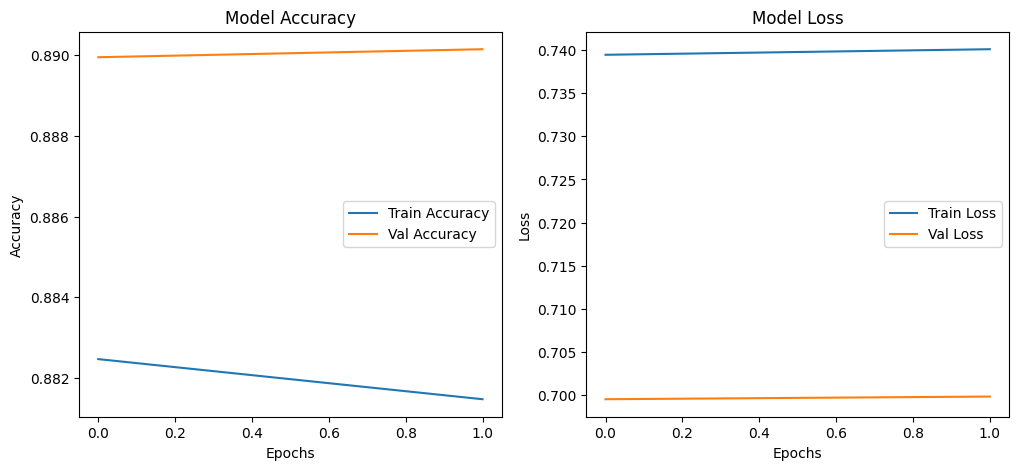

✅ Final Train Accuracy: 88.15%
✅ Final Val Accuracy: 89.01%


In [ ]:
##############################################
#  PLOTTING TRAINING RESULTS
##############################################
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"✅ Final Train Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"✅ Final Val Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")


In [ ]:
#############################################
#  REAL-TIME GESTURE PREDICTION WITH LETTER MODE
##############################################
# Reload model and class labels
model = load_model('my_model.keras')
with open('class_labels.txt', 'r') as file:
    class_labels = [line.strip() for line in file]

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

letter_mode = False  # Default: Normal mode
sentence = ""        # Accumulated sentence in letter mode
instructions_text = ("L: Toggle Letter Mode | SPACE: Append Letter | C: Clear Sentence | Q: Quit")

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to capture frame from webcam.")
        break

    cv2.putText(frame, instructions_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    # Define an enlarged ROI for hand gesture capture
    roi_x1, roi_y1 = 50, 50
    roi_x2, roi_y2 = 500, 500
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)
    roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    roi_resized = cv2.resize(roi, (img_size, img_size))
    roi_array = img_to_array(roi_resized) / 255.0
    roi_array = np.expand_dims(roi_array, axis=0)

    predictions = model.predict(roi_array)
    predicted_index = np.argmax(predictions[0])
    predicted_letter = class_labels[predicted_index]

    if letter_mode:
        cv2.putText(frame, "LETTER MODE ON", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(frame, f"Current Letter: {predicted_letter}", (10, 110),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(frame, f"Sentence: {sentence}", (10, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    else:
        cv2.putText(frame, f"Prediction: {predicted_letter}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    cv2.imshow("Sign Language Recognition", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('l'):
        letter_mode = not letter_mode
        if not letter_mode:
            sentence = ""  # Clear sentence when exiting letter mode
    elif key == ord('c'):
        sentence = ""  # Clear sentence buffer
    elif key == 32 and letter_mode:  # SPACE key appends current letter in letter mode
        sentence += predicted_letter

cap.release()
cv2.destroyAllWindows()
